In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import os
os.chdir('/Users/arpitha/Documents/295B/musicautobot')

In [ ]:
from musicautobot.numpy_encode import *
from musicautobot.utils.file_processing import process_all, process_file
from musicautobot.config import *
from musicautobot.music_transformer import *
from musicautobot.multitask_transformer import *
from musicautobot.numpy_encode import stream2npenc_parts

# Generate Music with Pretrained Model
### Load Pretrained

In [ ]:
# Config
config = multitask_config();

# Location of your midi files
midi_path =  Path('data/midi')

# Location of saved datset
data_path = Path('data/numpy')
# data_save_name = 'musicitem_data_save.pkl'

### MusicDataBunch: 
preps the data and converts it into a format that the model understands using fastai's databunch

In [ ]:
# Data
data = MusicDataBunch.empty(data_path)
vocab = data.vocab

In [ ]:
# Pretrained Model

pretrained_path = data_path/'pretrained/MultitaskSmallKeyC.pth'

In [ ]:
# Create a Learner with a language model from data and arch
learn = multitask_model_learner(data, pretrained_path=pretrained_path)

In [ ]:
example_dir = midi_path/'examples'
midi_files = get_files(example_dir, recurse=True, extensions='.mid'); midi_files[:5]

[PosixPath('data/midi/examples/Levels - Avicii - Verse.mid'),
 PosixPath('data/midi/examples/Scary Monsters And Nice Sprites - Skrillex - Pre-Chorus.mid'),
 PosixPath('data/midi/examples/Can You Feel The Love Tonight - Elton John - Verse.mid'),
 PosixPath('data/midi/examples/Locked Out Of Heaven - Bruno Mars - Chorus.mid'),
 PosixPath('data/midi/examples/In The Hall Of The Mountain King - Edvard Grieg - Intro.mid')]

In [ ]:
file = midi_files[0]; file

PosixPath('data/midi/examples/Levels - Avicii - Verse.mid')

In [ ]:
# Encode file 
item = MusicItem.from_file(file, data.vocab)

x = item.to_tensor()
x_pos = item.get_pos_tensor()

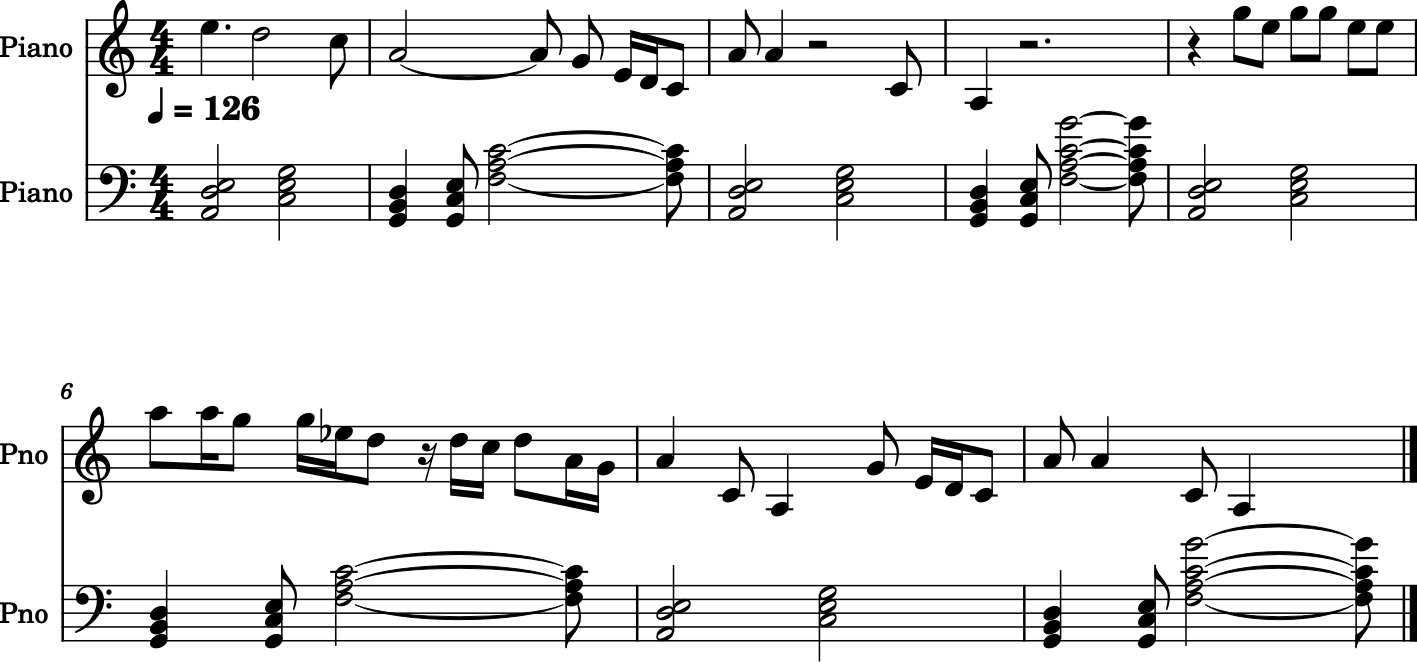

In [ ]:
item.show()

In [ ]:
item.play()

## Generate
MultitaskTransformer trains on 3 separate tasks. 
1. NextWord
2. Mask
3. Sequence to Sequence

Because we train on 3 separate tasks, we can actually generate some really cool note sequences.

1. NextWord/Autocomplete - Take a sequence of notes and predict the next note
 * 1a. Vanilla Language Model predictions - See [MusicTransformer](../music_transformer) project


2. Mask/Remix - Mask certain parts of song and remix those portions.
 * 2a. Note Masking - Mask all the note pitches and create a new sequence with different notes, but same exact rhythm
 * 2b. Duration Masking - Mask the note durations. Generate a new sequence with the same melody, but with a different rhythm


3. Seq2Seq/Translation - Generate melody from chords or vice versa. 
 * 3a. New Melody - Generate a new melody from existing chords
 * 3b. Harmonization - Generate chords to acompany an existing melody


## 1. NextWord/Autocomplete

Trim the song to only a few notes. Model will use these notes a seed and continue the idea

In [ ]:
seed_len = 6 # 4 beats = 1 bar
seed = item.trim_to_beat(seed_len)

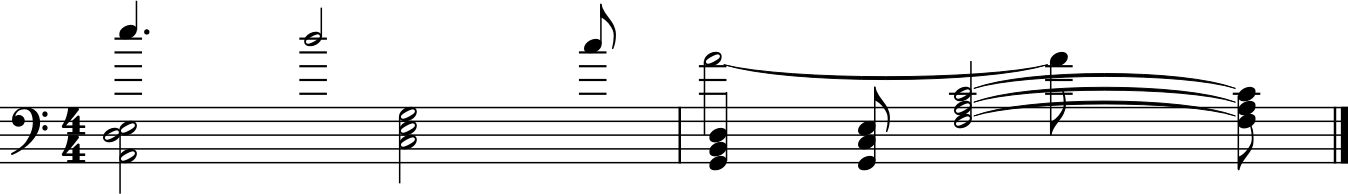

In [ ]:
seed.show()

In [ ]:
pred_nw, full = learn.predict_nw(seed, n_words=200)

/Users/arpitha/opt/anaconda3/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


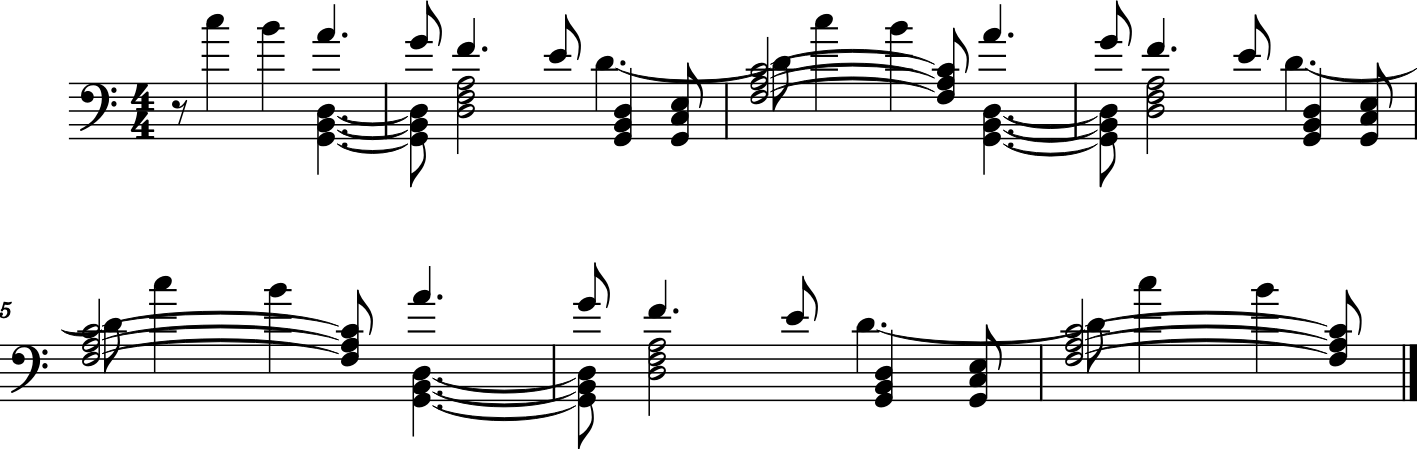

In [ ]:
pred_nw.show()

In [ ]:
pred_nw.play()

## 2. Mask/Remix
### 2a. Remix Notes

Mask all the note pitches. Model will create a new song with the same rhythm

In [ ]:
### Mask notes
note_item = item.mask_pitch();

In [ ]:
# Mask vs Original
list(zip(note_item.to_text(None)[:20], item.to_text(None)[:20]))

[('xxbos', 'xxbos'),
 ('xxpad', 'xxpad'),
 ('xxmask', 'n76'),
 ('d6', 'd6'),
 ('xxmask', 'n52'),
 ('d8', 'd8'),
 ('xxmask', 'n50'),
 ('d8', 'd8'),
 ('xxmask', 'n45'),
 ('d8', 'd8'),
 ('xxsep', 'xxsep'),
 ('d6', 'd6'),
 ('xxmask', 'n74'),
 ('d8', 'd8'),
 ('xxsep', 'xxsep'),
 ('d2', 'd2'),
 ('xxmask', 'n55'),
 ('d8', 'd8'),
 ('xxmask', 'n52'),
 ('d8', 'd8')]

In [ ]:
pred_note = learn.predict_mask(note_item)

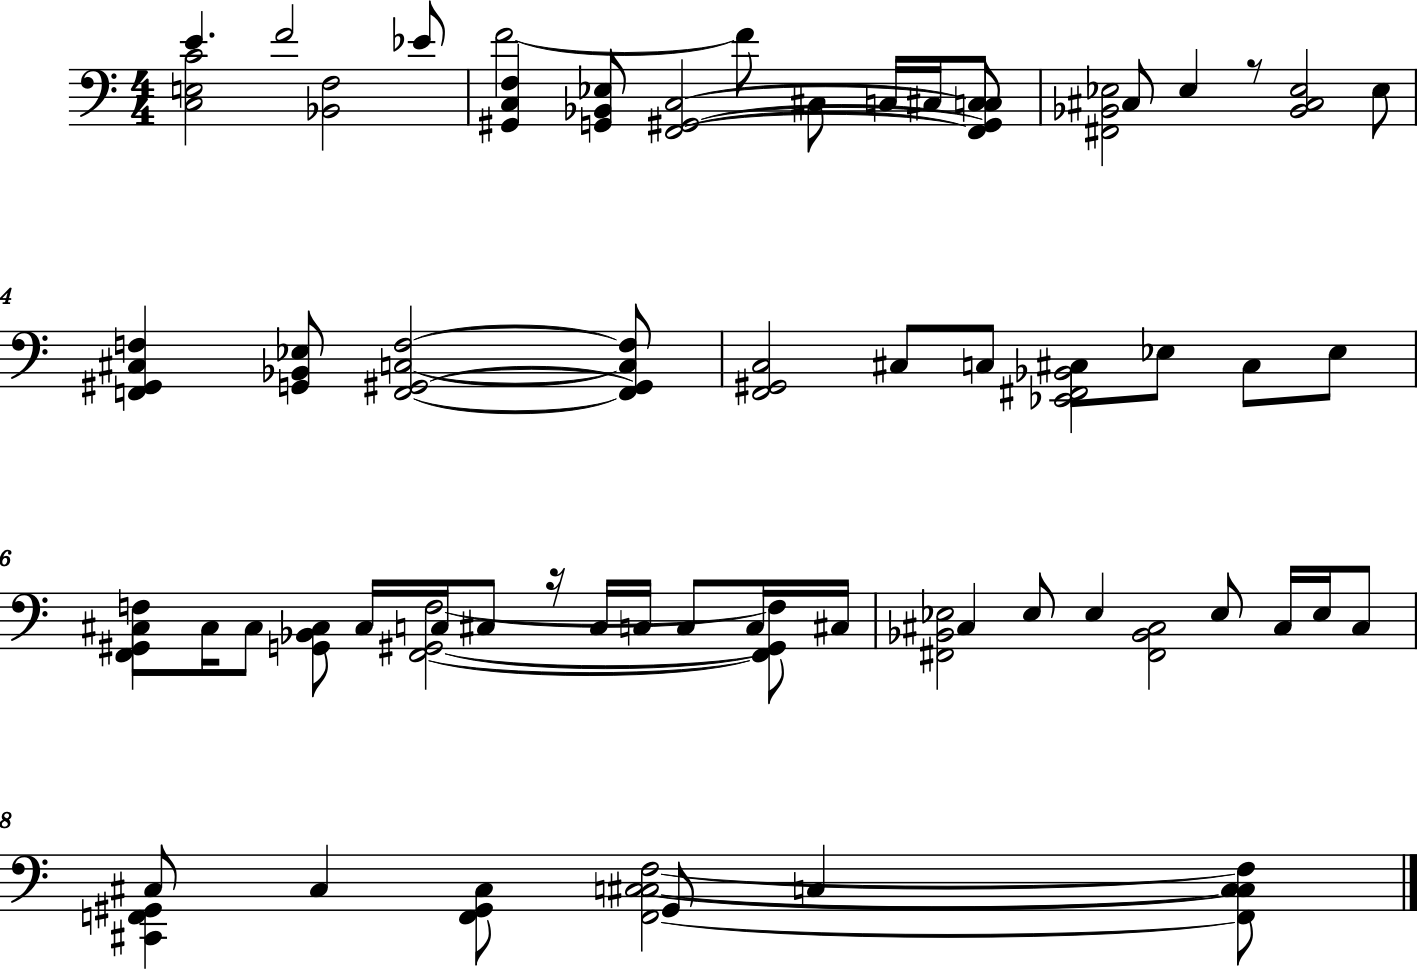

In [ ]:
pred_note.show()

In [ ]:
pred_note.play()

### 2b. Remix rhythm

Mask note durations. Same notes, different rhythm



In [ ]:
# duration mask
dur_item = item.mask_duration()

In [ ]:
# Mask vs Original
list(zip(dur_item.to_text(None)[:10], item.to_text(None)[:10]))

[('xxbos', 'xxbos'),
 ('xxpad', 'xxpad'),
 ('n76', 'n76'),
 ('xxmask', 'd6'),
 ('n52', 'n52'),
 ('xxmask', 'd8'),
 ('n50', 'n50'),
 ('xxmask', 'd8'),
 ('n45', 'n45'),
 ('xxmask', 'd8')]

### Hyperparameters:
1. Temperature adjusts how "creative" the predictions will be. You can control the amount of variation in the pitch and/or rhythm.
2. TopK/TopP - filters out the lowest probability tokens. It makes sure outliers never get chosen, even if they have the tiniest bit of probability

In [ ]:
dur_pred = learn.predict_mask(dur_item, temperatures=(0.8,0.8), top_k=40, top_p=0.6)

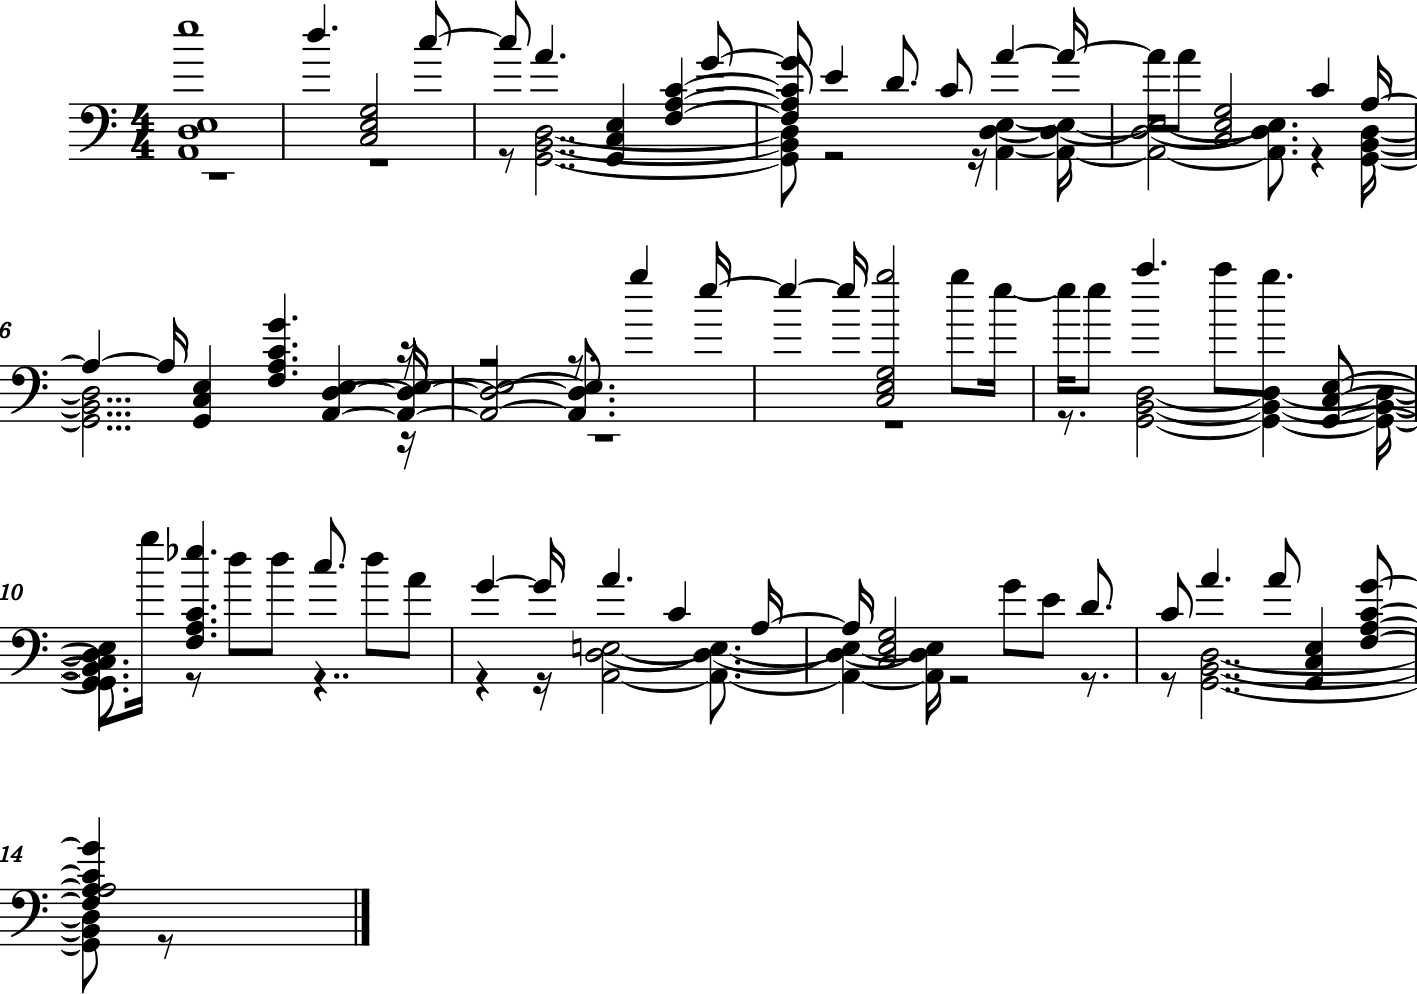

In [ ]:
dur_pred.show()

In [ ]:
dur_pred.play()

## 3. Seq2Seq/Translation
Load MultitrackItem.

MultitrackItem keeps track of which notes are part of the melody and which notes are part of the chords.  
This info is needed for translation task

In [ ]:
multitrack_item = MultitrackItem.from_file(file, vocab)

In [ ]:
melody, chords = multitrack_item.melody, multitrack_item.chords

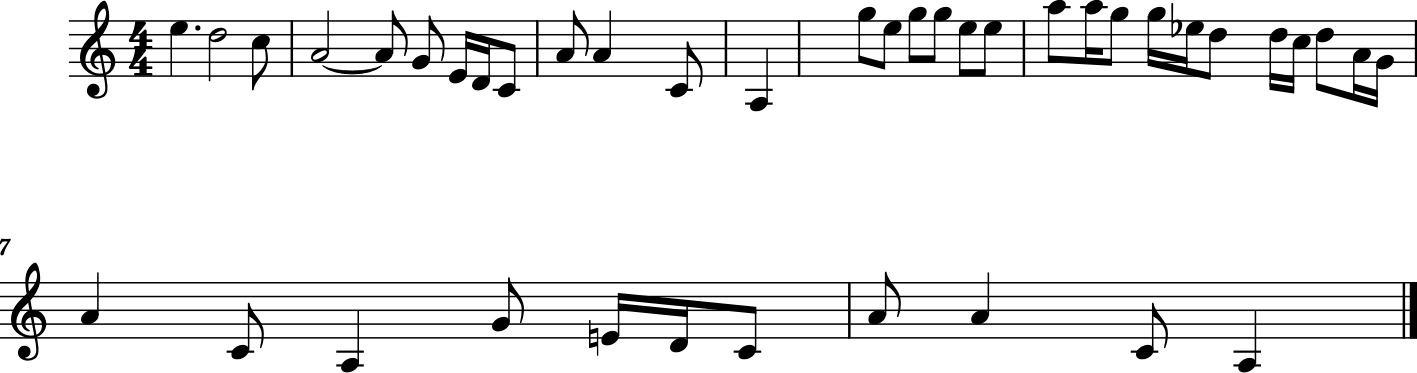

In [ ]:
melody.show()

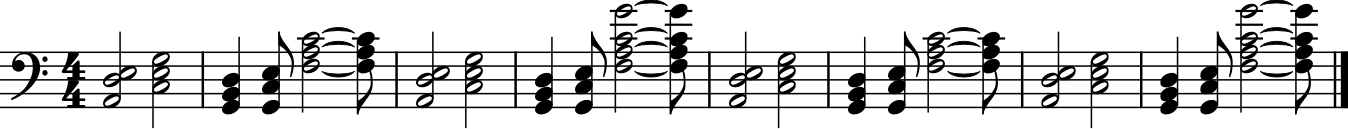

In [ ]:
chords.show()

In [ ]:
multitrack_item.play()

## 3a. Create Melody

Use existing chord progression to generate a new melody

In [ ]:
# Use a seed for the melody
partial_melody = melody.trim_to_beat(4)

# Or generate from an empty sequence
empty_melody = MusicItem.empty(vocab, seq_type=SEQType.Melody)

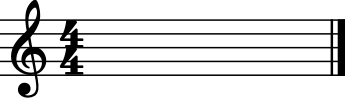

In [ ]:
seed_melody = empty_melody; seed_melody.show()

Predicted past counter-part length. Returning early


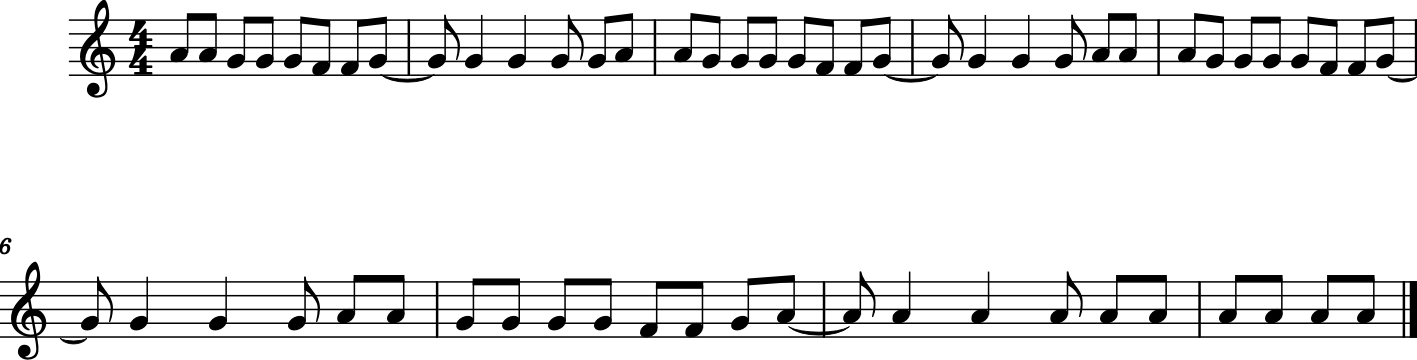

In [ ]:
pred_melody = learn.predict_s2s(chords, seed_melody, use_memory=True)
pred_melody.show()

In [ ]:
pred_melody.play()

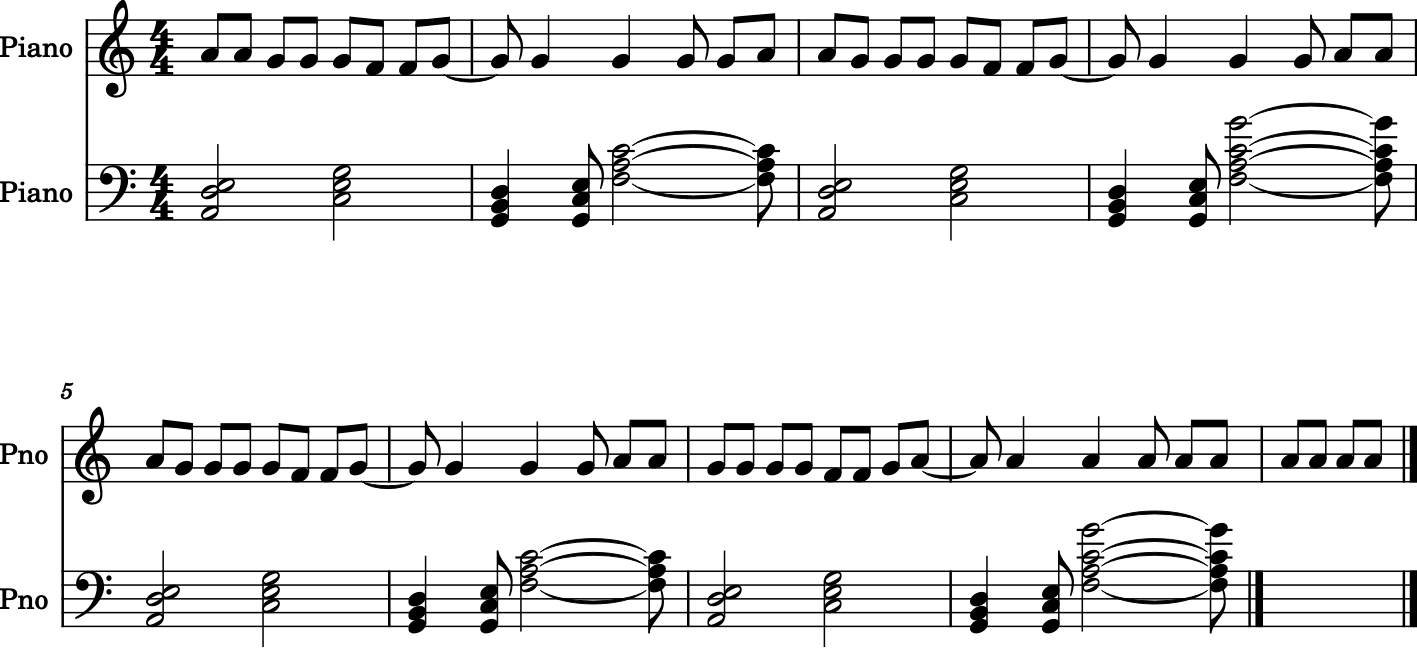

In [ ]:
combined = MultitrackItem(pred_melody, chords)
combined.show()

In [ ]:
combined.play()

## 3b. Harmonization

Generate chords to accompany an existing melody

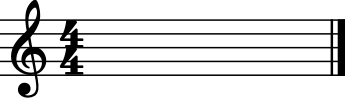

In [ ]:
# partial_chords = chords.trim_to_beat(3);
# partial_chords.show()

empty_chords = MusicItem.empty(vocab, seq_type=SEQType.Chords); empty_chords.show()

In [ ]:
pred_chord = learn.predict_s2s(input_item=melody, target_item=empty_chords)

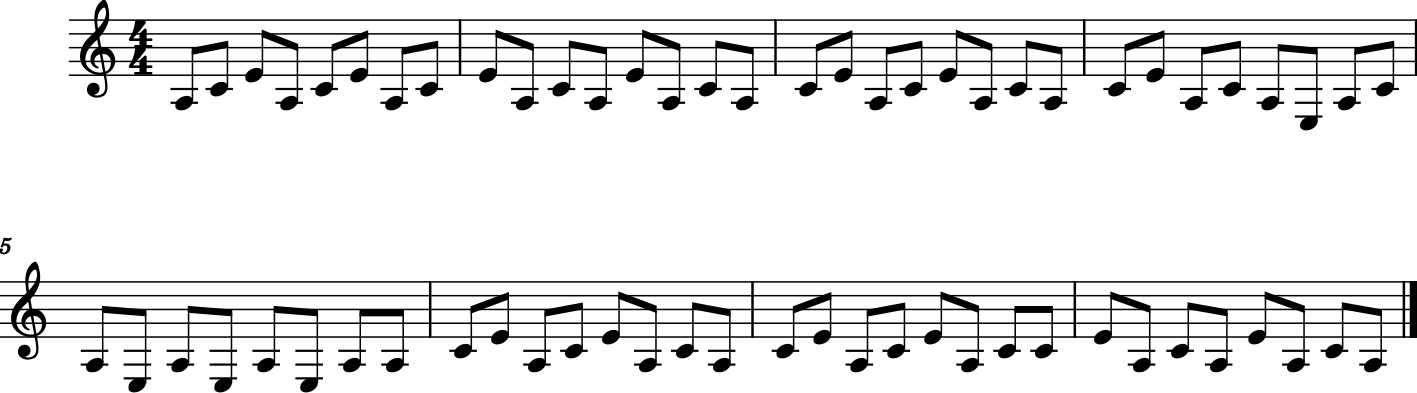

In [ ]:
pred_chord.show()

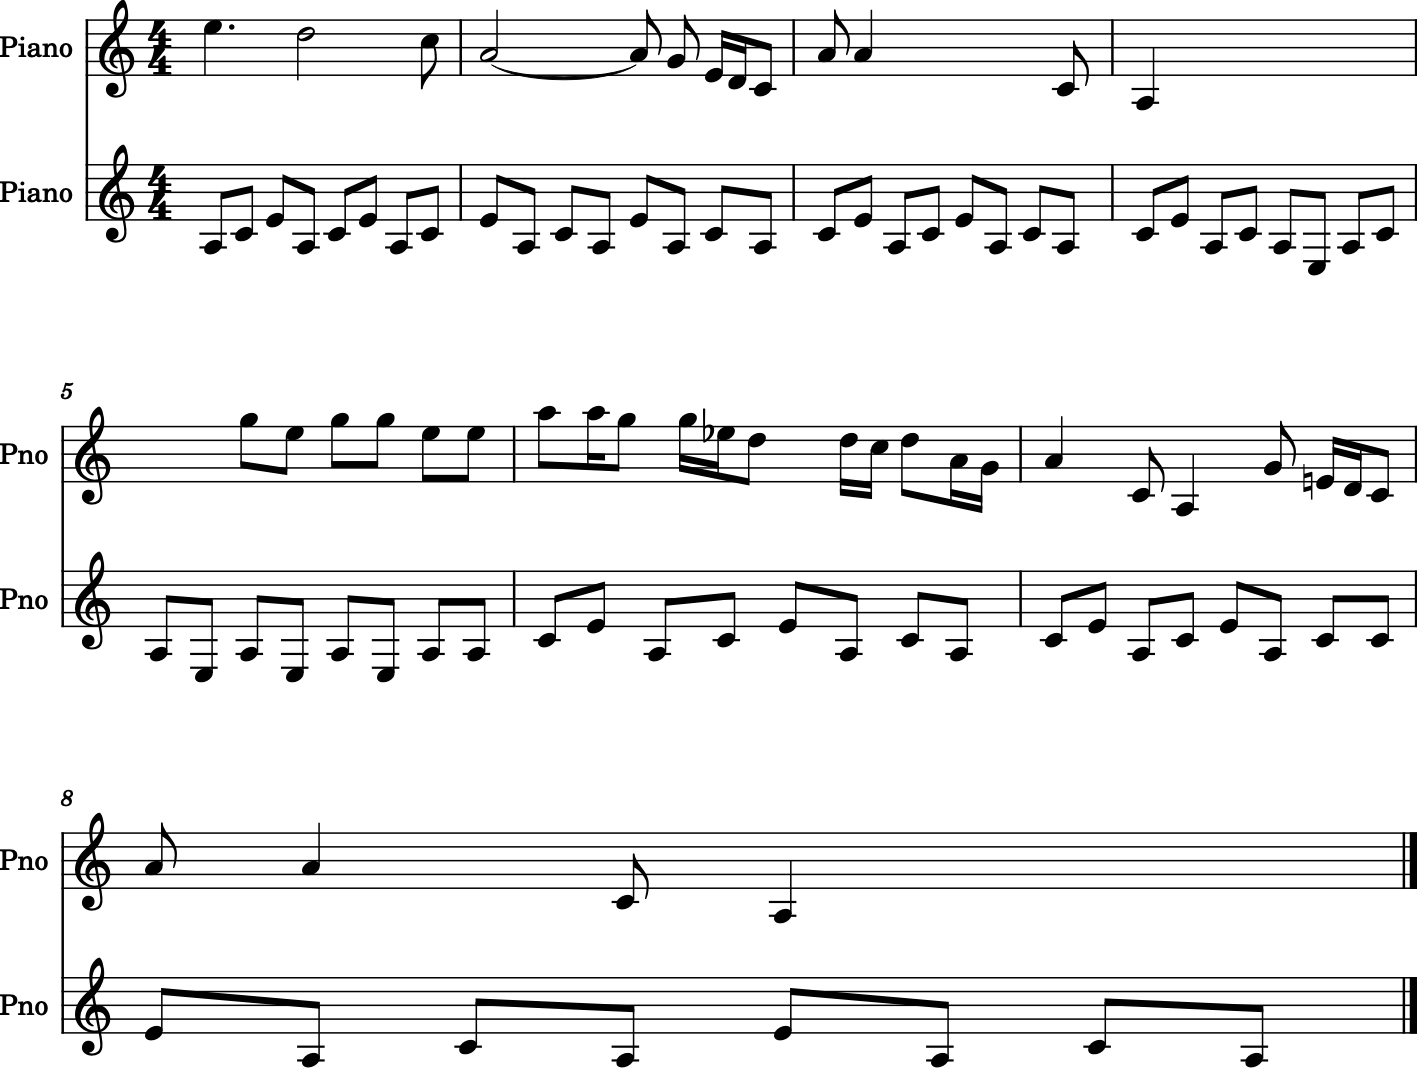

In [ ]:
combined = MultitrackItem(melody, pred_chord)
combined.show()

In [ ]:
combined.play()

# Experimenting with finetuning the model

### Model architecture:
1. Encoder - Bi-directional attention layers
2. Decoder - Uni-directional double-stacked attention layers
3. Head - Dense layer for token decoding

### Forward Prop:
1. If the input is masked ('msk'), train the encoder.
2. If the input is shifted ('lm'), train the decoder.
3. If the input contains both translation input ('enc') and previous tokens ('dec'), use both encoder and decoder.

In [ ]:
print(learn.model)

MultiTransformer(
  (encoder): MTEncoder(
    (embed): TransformerEmbedding(
      (embed): Embedding(312, 512, padding_idx=1)
      (pos_enc): PositionalEncoding()
      (beat_enc): Embedding(32, 512, padding_idx=0)
      (bar_enc): Embedding(1024, 512, padding_idx=0)
      (drop): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0): MTEncoderBlock(
        (mha1): MemMultiHeadRelativeAttentionKV(
          (q_wgt): Linear(in_features=512, out_features=512, bias=True)
          (k_wgt): Linear(in_features=512, out_features=512, bias=True)
          (v_wgt): Linear(in_features=512, out_features=512, bias=True)
          (drop_att): Dropout(p=0.1, inplace=False)
          (drop_res): Dropout(p=0.1, inplace=False)
          (ln): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (r_attn): Linear(in_features=512, out_features=512, bias=True)
        )
        (mha2): MemMultiHeadRelativeAttentionKV(
          (q_wgt): Linear(in_features=512, out_features=

### We can decide to divide the model in 17 blocks

8 Encoder
8 Decoder
1 head
In this case, we can split our model in this way :



In [ ]:
list_layers = [learn.model.encoder.embed,
              learn.model.encoder.layers[0],
#               learn.model.encoder.layers[1]
#               learn.model.encoder.layers[2],
#               learn.model.encoder.layers[3],
#               learn.model.encoder.layers[4],
#               learn.model.encoder.layers[5],
#               learn.model.encoder.layers[6],
#               learn.model.encoder.layers[7],
#               learn.model.decoder.embed,
#               learn.model.decoder.layers[0],
#               learn.model.decoder.layers[1],
#               learn.model.decoder.layers[2],
#               learn.model.decoder.layers[3],
#               learn.model.decoder.layers[4],
#               learn.model.decoder.layers[5],
#               learn.model.decoder.layers[6],
#               learn.model.decoder.layers[7],
#               learn.model.head
              ]

In [ ]:
learn.summary

<bound method model_summary of MultitaskLearner(data=MusicDataBunch;

Train: LabelList (0 items)
x: MusicItemList

y: LMLabelList

Path: data/numpy;

Valid: LabelList (0 items)
x: MusicItemList

y: LMLabelList

Path: data/numpy;

Test: None, model=MultiTransformer(
  (encoder): MTEncoder(
    (embed): TransformerEmbedding(
      (embed): Embedding(312, 512, padding_idx=1)
      (pos_enc): PositionalEncoding()
      (beat_enc): Embedding(32, 512, padding_idx=0)
      (bar_enc): Embedding(1024, 512, padding_idx=0)
      (drop): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0): MTEncoderBlock(
        (mha1): MemMultiHeadRelativeAttentionKV(
          (q_wgt): Linear(in_features=512, out_features=512, bias=True)
          (k_wgt): Linear(in_features=512, out_features=512, bias=True)
          (v_wgt): Linear(in_features=512, out_features=512, bias=True)
          (drop_att): Dropout(p=0.1, inplace=False)
          (drop_res): Dropout(p=0.1, inplace=False)
          

In [ ]:
learn.split(list_layers)

MultitaskLearner(data=MusicDataBunch;

Train: LabelList (0 items)
x: MusicItemList

y: LMLabelList

Path: data/numpy;

Valid: LabelList (0 items)
x: MusicItemList

y: LMLabelList

Path: data/numpy;

Test: None, model=MultiTransformer(
  (encoder): MTEncoder(
    (embed): TransformerEmbedding(
      (embed): Embedding(312, 512, padding_idx=1)
      (pos_enc): PositionalEncoding()
      (beat_enc): Embedding(32, 512, padding_idx=0)
      (bar_enc): Embedding(1024, 512, padding_idx=0)
      (drop): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0): MTEncoderBlock(
        (mha1): MemMultiHeadRelativeAttentionKV(
          (q_wgt): Linear(in_features=512, out_features=512, bias=True)
          (k_wgt): Linear(in_features=512, out_features=512, bias=True)
          (v_wgt): Linear(in_features=512, out_features=512, bias=True)
          (drop_att): Dropout(p=0.1, inplace=False)
          (drop_res): Dropout(p=0.1, inplace=False)
          (ln): LayerNorm((512,), eps=1e-

In [ ]:
num_groups = len(learn.layer_groups)

In [ ]:
print('Learner split in',num_groups,'groups')

Learner split in 2 groups


In [ ]:
print(learn.layer_groups)

[Sequential(
  (0): Embedding(312, 512, padding_idx=1)
  (1): PositionalEncoding()
  (2): Embedding(32, 512, padding_idx=0)
  (3): Embedding(1024, 512, padding_idx=0)
  (4): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=512, out_features=512, bias=True)
  (1): Linear(in_features=512, out_features=512, bias=True)
  (2): Linear(in_features=512, out_features=512, bias=True)
  (3): Dropout(p=0.1, inplace=False)
  (4): Dropout(p=0.1, inplace=False)
  (5): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (6): Linear(in_features=512, out_features=512, bias=True)
  (7): Linear(in_features=512, out_features=512, bias=True)
  (8): Linear(in_features=512, out_features=512, bias=True)
  (9): Linear(in_features=512, out_features=512, bias=True)
  (10): Dropout(p=0.1, inplace=False)
  (11): Dropout(p=0.1, inplace=False)
  (12): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (13): Linear(in_features=512, out_features=512, bias=True)
  (14): Linear(in_features=

In [ ]:
learn.summary()

Exception: This is an empty `Learner` and `Learner.summary` requires some data to pass through the model.